In [1]:
# Importação das bibliotecas usadas no desenvolvimento do projeto
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from statistics import mean, median

In [2]:
# Importação dos conjutos de amostras
dados_treino = pd.read_csv("conjunto_de_treinamento.csv", delimiter=",", decimal=".")
dados_teste = pd.read_csv("conjunto_de_teste.csv", delimiter=",", decimal=".")

In [3]:
dados_teste.head()

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,...,estado_onde_trabalha,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha
0,20001,1,25,presencial,1,M,37,2,0,0,...,,N,,0,0.0,0.0,0.0,0.0,384.0,384.0
1,20002,1,10,internet,1,F,31,2,0,0,...,RJ,N,,0,9.0,5.0,NaN,NaN,275.0,275.0
2,20003,1,10,internet,1,F,18,2,0,0,...,RS,N,,0,9.0,2.0,NaN,NaN,948.0,948.0
3,20004,1,10,presencial,1,F,55,2,0,0,...,,N,,0,9.0,1.0,0.0,0.0,581.0,581.0
4,20005,1,10,presencial,1,F,55,1,0,0,...,,N,,0,0.0,1.0,0.0,0.0,573.0,573.0


In [4]:
dados_treino.head()

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,...,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,...,N,,0,9.0,1.0,0.0,0.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,0,...,N,,0,2.0,5.0,NaN,NaN,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,0,...,N,,0,NaN,NaN,NaN,NaN,450.0,450.0,1
3,4,1,20,internet,1,M,37,1,1,0,...,Y,54,0,9.0,2.0,NaN,NaN,932.0,932.0,1
4,5,7,1,internet,1,F,51,1,3,0,...,N,,0,9.0,5.0,NaN,NaN,440.0,440.0,1


# Verificação de Outliers

Após gerar os gráficos de todas as colunas do datasets, percebeu-se que existe um outlier que possui 53 dependentes cadastrados. As demais variáveis não apresentam outliers.

C:\Users\assis\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


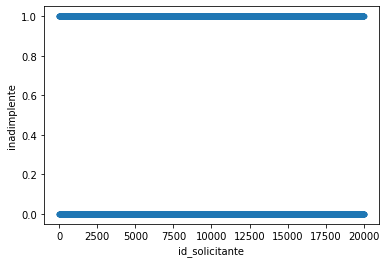

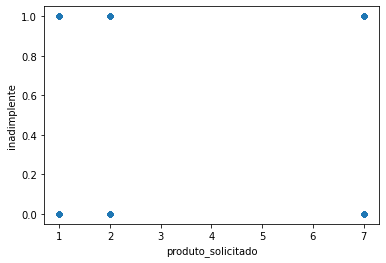

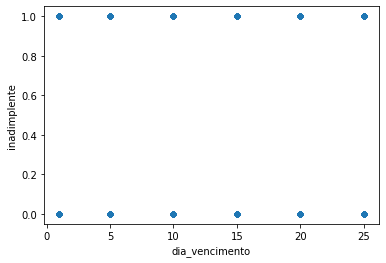

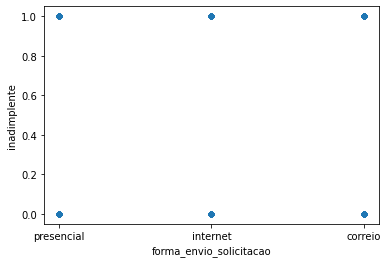

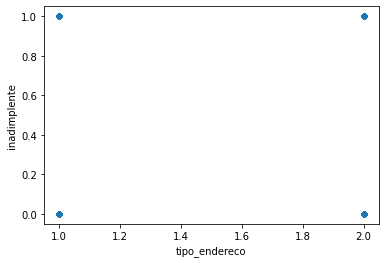

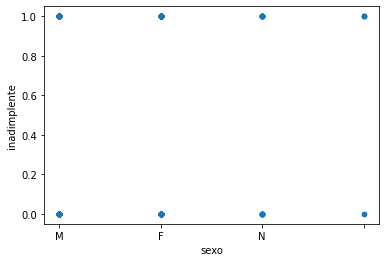

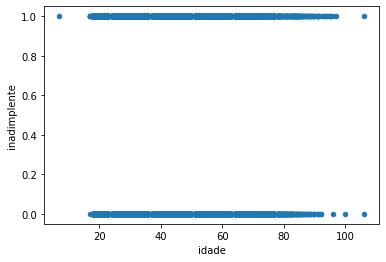

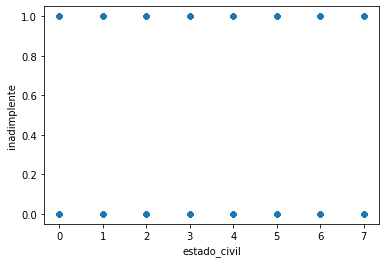

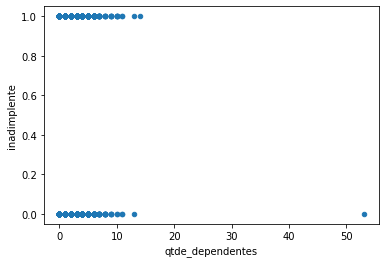

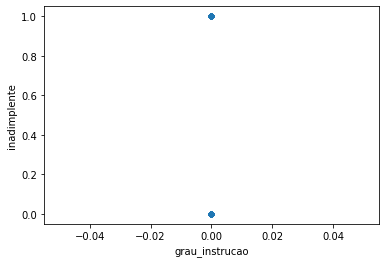

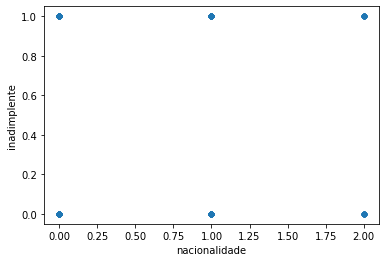

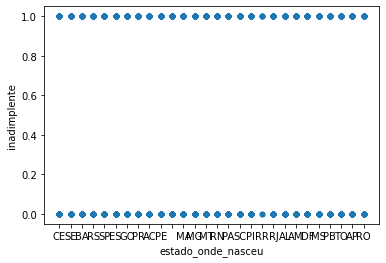

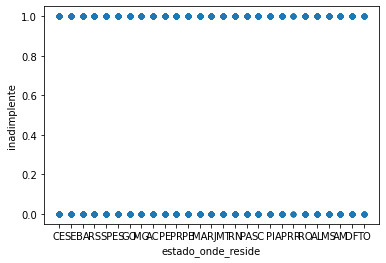

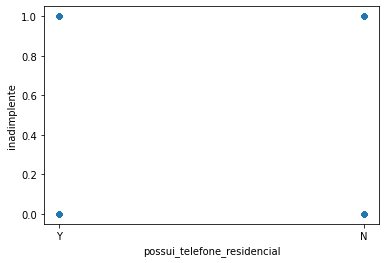

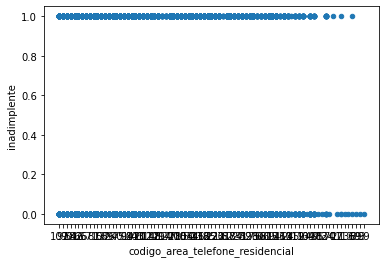

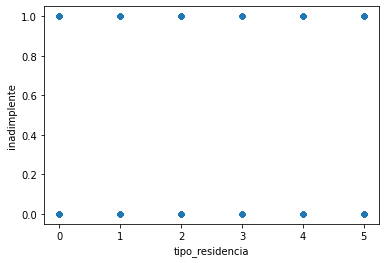

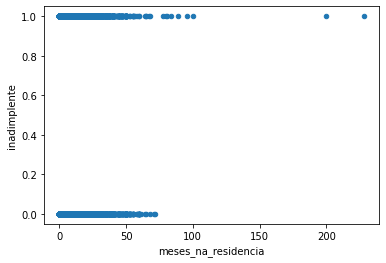

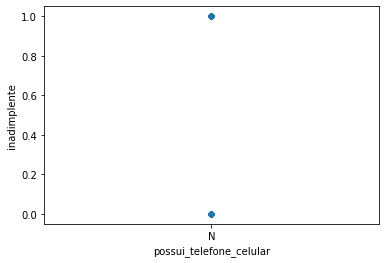

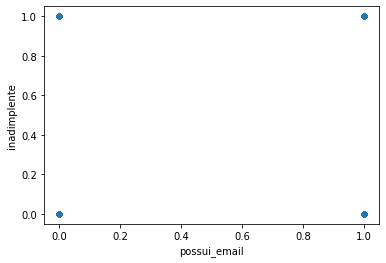

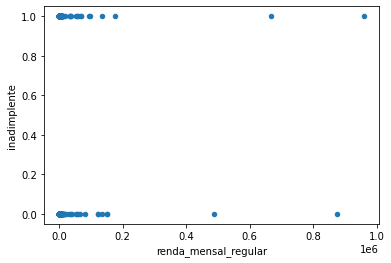

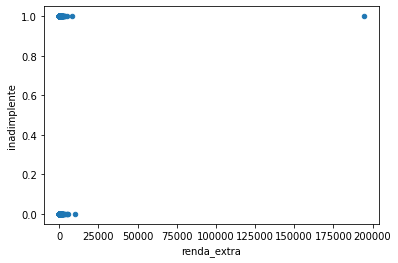

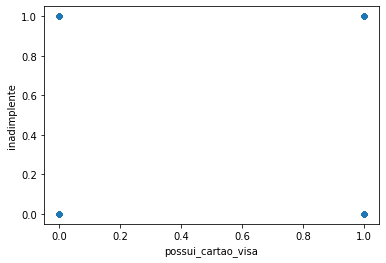

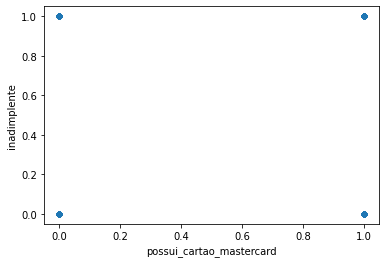

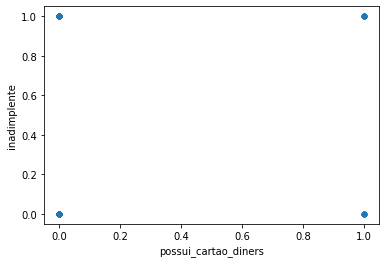

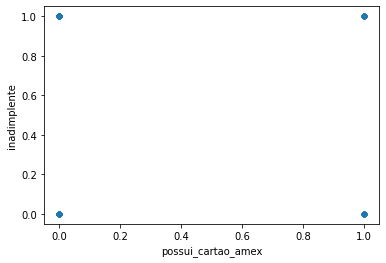

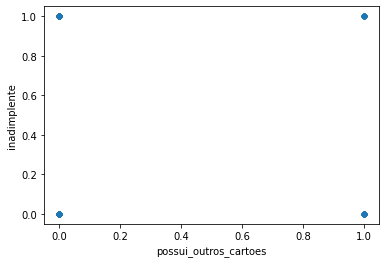

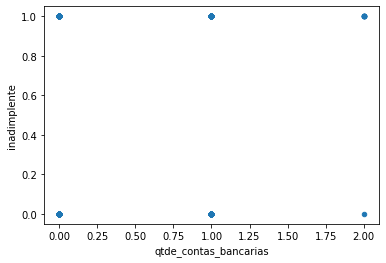

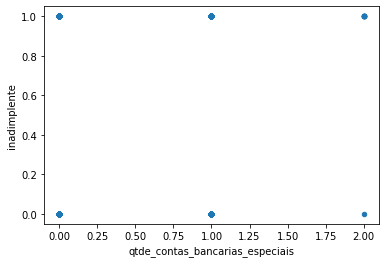

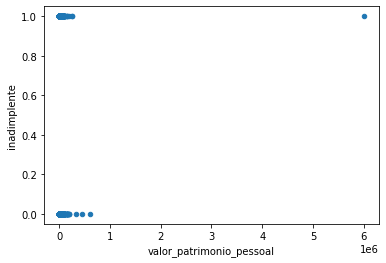

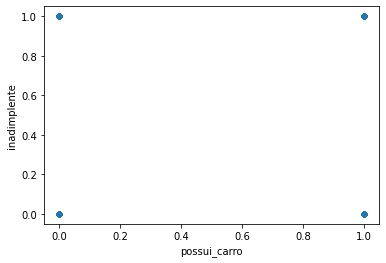

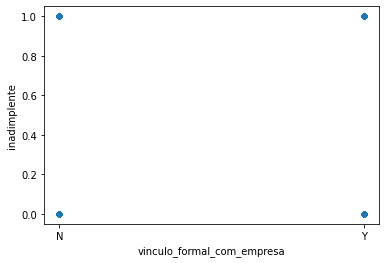

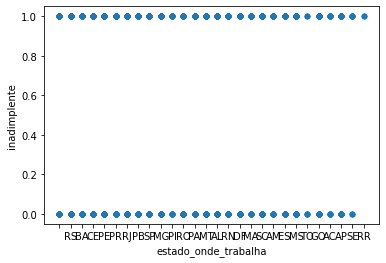

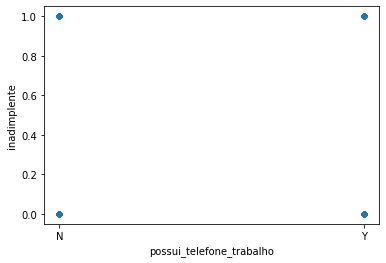

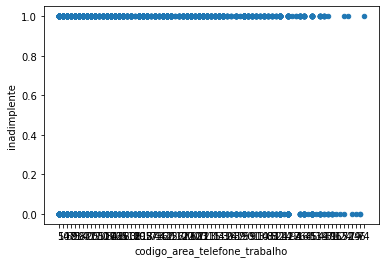

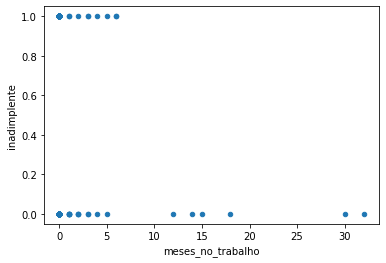

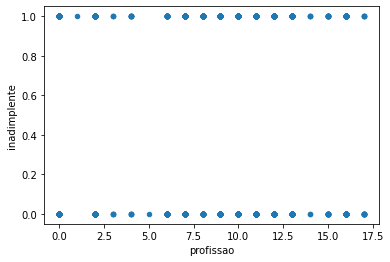

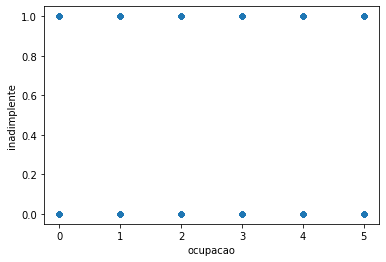

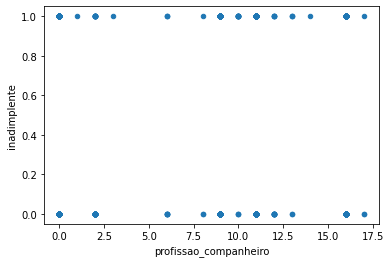

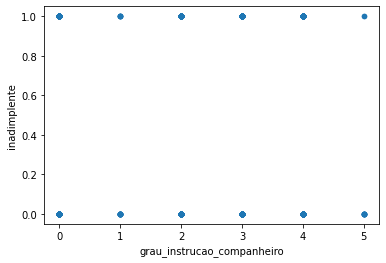

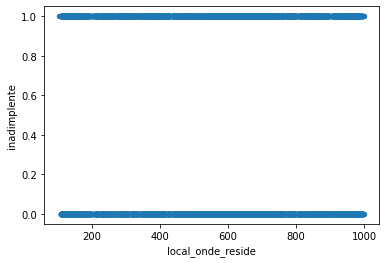

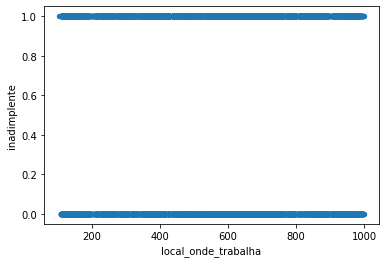

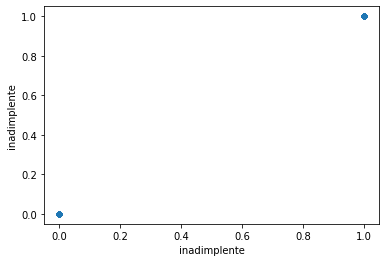

In [5]:
for coluna in dados_treino.columns:
     dados_treino.plot.scatter(x=coluna, y='inadimplente')

dados_treino[dados_treino['qtde_dependentes'] > 15] #printa o outlier
dados_treino = dados_treino.drop(8489)

# Tratamento de dados

## Lidando com os NaN

Como é possível observar nas 5 primeiras linhas dos dados de treino e teste, existem dados faltantes "NaN". Dado isto, quantifica-se a perda de dados ao simplesmente eliminar as linhas com NaN.

In [6]:
linha_treino_com_na = dados_treino.shape[0]
linha_treino_sem_na = dados_treino.dropna().shape[0]

print("Perda de %0.2f%% dos dados de treino ao retirar linhas com informações faltantes." %(100 - linha_treino_sem_na*100/linha_treino_com_na))

Perda de 65.12% dos dados de treino ao retirar linhas com informações faltantes.


A perda de 65.12% do dataset é algo péssimo para o modelo pois perde grande parte da representação do universo. Para prosseguir sem perder essas amostras, optou-se por substituir os NaN de forma a manter a característica das distribuições.

Para fazer essas substituições, primeiro faz-se o tratamento dos dados nos datasets de treino e teste. A seguir seguem as modificaçãoes feitas sobre os dados.

## Conversão dos dados e remoção de colunas

Primeiramente faz-se a análise do arquivo "dicionario_de_dados.xlsx" e segue-se as recomendações para remover as colunas com erro de preenchimento e colunas que visivelmente agregam pouco valor (por ter alta correlação com outra coluna. Ex. colunas de estados onde trabalha, habita e nasceu).

In [7]:
# forma_envio_solicitacao -> Abrir em 3 colunas (internet, correio e presencial)
# sexo -> Abrir em 3 colunas (masculino, feminino, nao informado). Se vazio colocar N
# grau_instrucao -> Remover
# estado_onde_nasceu -> Remover, possui alta correlação  com "estado_onde_reside"
# estado_onde_reside -> Transformar em regiões do país
# possui_telefone_residencial -> Transformar em 1 - Sim 0 - Nao
# possui_telefone_celular ->  Remover
# qtde_contas_bancarias_especiais -> Remover
# vinculo_formal_com_empresa -> Transformar em 1 - Sim 0 - Nao
# estado_onde_trabalha -> Inútil, apenas 0.2% está preenchido
# possui_telefone_trabalho -> Transformar em 1 - Sim 0 - Nao
# meses_no_trabalho -> Remover

# deleta as colunas desnecessárias/com dados corrompidos
dados_treino = dados_treino.drop(columns=['id_solicitante', 'grau_instrucao', 'possui_telefone_celular',\
                                          'qtde_contas_bancarias_especiais', 'meses_no_trabalho', 'estado_onde_trabalha',\
                                         'codigo_area_telefone_trabalho', 'codigo_area_telefone_residencial', 'estado_onde_nasceu'])
dados_teste = dados_teste.drop(columns=['grau_instrucao', 'possui_telefone_celular',\
                                          'qtde_contas_bancarias_especiais', 'meses_no_trabalho', 'estado_onde_trabalha',\
                                         'codigo_area_telefone_trabalho', 'codigo_area_telefone_residencial', 'estado_onde_nasceu'])

In [8]:
# splita as colunas na lista "valores_a_trocar" em uma coluna para cada opção dentre as possíveis
# caso o valor de uma linha da coluna sexo seja NaN, troca por N - Não informado
valores = {'sexo':'N'}

valores_a_trocar = ['possui_telefone_residencial', 'vinculo_formal_com_empresa', 'possui_telefone_trabalho', 'forma_envio_solicitacao', 'sexo']

dados_treino = dados_treino.fillna(value=valores)
dados_teste = dados_teste.fillna(value=valores)

dados_treino = pd.get_dummies(dados_treino, columns=valores_a_trocar)
dados_teste = pd.get_dummies(dados_teste, columns=valores_a_trocar)

# drop necessário para tirar uma coluna de bug
dados_treino = dados_treino.drop(columns=['sexo_ '])
dados_teste = dados_teste.drop(columns=['sexo_ '])

In [9]:
# Troca os estados das colunas na lista abaixo pela região do estado e faz o get_dummie da coluna
valores_a_trocar = ['estado_onde_reside']

dicionario = {'AC':'NO', 'AP':'NO', 'AM':'NO', 'PA':'NO', 'RO':'NO', 'RR':'NO', 'TO':'NO',\
              'MA':'NE', 'PI':'NE', 'CE':'NE', 'RN':'NE', 'PB':'NE', 'PE':'NE', \
             'AL':'NE', 'SE':'NE', 'BA':'NE', 'MT':'CO', 'MS':'CO', 'GO':'CO',\
             'DF':'CO', 'RJ':'SD', 'MG':'SD', 'SP':'SD', 'ES':'SD', 'SC':'SU', 'PR':'SU', 'RS':'SU'}

for coluna in valores_a_trocar:
    dados_treino[coluna] = dados_treino[coluna].map(dicionario, na_action='NC')
    dados_teste[coluna] = dados_teste[coluna].map(dicionario, na_action='NC')
    
dados_treino = pd.get_dummies(dados_treino, columns=valores_a_trocar)
dados_teste = pd.get_dummies(dados_teste, columns=valores_a_trocar)

Após as tratativas nas últimas 4 células, finalmente tem-se dados com todas as linhas preenchidas. Ao longo das tratativas alguns dados foram transformados e/ou removidos, alterando de alguma forma na precisão do modelo.

Agora, com todos os dados transformados pode-se substituir os valores faltantes por alguma métrica.

## Substituindo os dados faltantes

A fim de simplificar as operações, substitui-se os dados faltantes das colunas não quantitativas pela mediana e os das colunas quantitativas pela média.

In [10]:
# Substitui os dados NaN pela mediana ou média da coluna

colunas_quantitativas = ['idade', 'meses_na_residencia']
# as variáveis de renda não entram nessa lista pois a média colocaria um viés na realidade do universo das amostras

for coluna in dados_treino.columns:
    if coluna == 'inadimplente':
        continue
    elif coluna in colunas_quantitativas:
        dados_teste[[coluna]] = dados_teste[[coluna]].fillna(dados_teste.mean())
        dados_treino[[coluna]] = dados_treino[[coluna]].fillna(dados_treino.mean())
    else:
        dados_teste[[coluna]] = dados_teste[[coluna]].fillna(dados_teste.median())
        dados_treino[[coluna]] = dados_treino[[coluna]].fillna(dados_treino.median())

# Criando os modelos classificadores

Neste ponto os dados estão todos em valor numérico com todas as colunas preenchidas. Pode-se, portanto, prosseguir para a criação do modelo preditivo.

## Escolha de variáveis

In [11]:
# calcula o coeficiente de Pearson para cada coluna em relação ao alvo
pearson_coef = {coluna:round(abs(pearsonr(dados_treino[coluna], dados_treino['inadimplente'])[0]),4) for coluna in dados_treino.columns}

pearson_coef

{'produto_solicitado': 0.0301,
 'dia_vencimento': 0.0804,
 'tipo_endereco': 0.0044,
 'idade': 0.1207,
 'estado_civil': 0.0313,
 'qtde_dependentes': 0.0207,
 'nacionalidade': 0.0005,
 'tipo_residencia': 0.0181,
 'meses_na_residencia': 0.0323,
 'possui_email': 0.0057,
 'renda_mensal_regular': 0.0009,
 'renda_extra': 0.0058,
 'possui_cartao_visa': 0.0013,
 'possui_cartao_mastercard': 0.02,
 'possui_cartao_diners': 0.0025,
 'possui_cartao_amex': 0.0011,
 'possui_outros_cartoes': 0.0032,
 'qtde_contas_bancarias': 0.0142,
 'valor_patrimonio_pessoal': 0.0012,
 'possui_carro': 0.0127,
 'profissao': 0.0126,
 'ocupacao': 0.0386,
 'profissao_companheiro': 0.0232,
 'grau_instrucao_companheiro': 0.0228,
 'local_onde_reside': 0.0189,
 'local_onde_trabalha': 0.0189,
 'inadimplente': 1.0,
 'possui_telefone_residencial_N': 0.0808,
 'possui_telefone_residencial_Y': 0.0808,
 'vinculo_formal_com_empresa_N': 0.0062,
 'vinculo_formal_com_empresa_Y': 0.0062,
 'possui_telefone_trabalho_N': 0.016,
 'possui_tel

In [12]:
from operator import itemgetter

coef_ordenados = sorted(pearson_coef.items(), key=itemgetter(1))
media_coef = []

for indice, tupla in enumerate(coef_ordenados):
    coef = tupla[1]
    coluna = tupla[0]
    for colunas in dados_treino.columns:
        if colunas not in ['inadimplente', coluna]:
            media_coef.append(abs(round(pearsonr(dados_treino[coluna], dados_treino[colunas])[0],2)))
    correlacao_media = mean(media_coef)
    coef_ordenados[indice] = [coluna, coef, round(correlacao_media, 4), round(coef/correlacao_media, 4)]

In [13]:
coef_ordenados = sorted(coef_ordenados, key=itemgetter(1))
coef_ordenados

[['nacionalidade', 0.0005, 0.0679, 0.0074],
 ['renda_mensal_regular', 0.0009, 0.0382, 0.0236],
 ['possui_cartao_amex', 0.0011, 0.0317, 0.0347],
 ['valor_patrimonio_pessoal', 0.0012, 0.0268, 0.0448],
 ['possui_cartao_visa', 0.0013, 0.0284, 0.0458],
 ['sexo_N', 0.0014, 0.0257, 0.0545],
 ['possui_cartao_diners', 0.0025, 0.0245, 0.1019],
 ['possui_outros_cartoes', 0.0032, 0.0226, 0.1413],
 ['tipo_endereco', 0.0044, 0.0218, 0.2016],
 ['possui_email', 0.0057, 0.0286, 0.1995],
 ['renda_extra', 0.0058, 0.0263, 0.2202],
 ['vinculo_formal_com_empresa_N', 0.0062, 0.0331, 0.1871],
 ['vinculo_formal_com_empresa_Y', 0.0062, 0.0389, 0.1595],
 ['forma_envio_solicitacao_internet', 0.0063, 0.0446, 0.1412],
 ['estado_onde_reside_SD', 0.0074, 0.0465, 0.1591],
 ['estado_onde_reside_NO', 0.0099, 0.0468, 0.2116],
 ['profissao', 0.0126, 0.0484, 0.2602],
 ['possui_carro', 0.0127, 0.0519, 0.2447],
 ['forma_envio_solicitacao_presencial', 0.0137, 0.0552, 0.2484],
 ['qtde_contas_bancarias', 0.0142, 0.0578, 0.2455]

In [14]:
indice_aceitavel = 29 #30 ou 29
variaveis_escolhidas = []

for item in coef_ordenados[indice_aceitavel:]:
    variaveis_escolhidas.append(item[0])

variaveis_escolhidas

['grau_instrucao_companheiro',
 'profissao_companheiro',
 'sexo_M',
 'sexo_F',
 'produto_solicitado',
 'estado_civil',
 'meses_na_residencia',
 'estado_onde_reside_NE',
 'ocupacao',
 'estado_onde_reside_SU',
 'dia_vencimento',
 'possui_telefone_residencial_N',
 'possui_telefone_residencial_Y',
 'idade',
 'inadimplente']

In [15]:
dados_treino = dados_treino[variaveis_escolhidas]
dados_teste = dados_teste[variaveis_escolhidas[:-1]]

## Separação dos dados

In [16]:
#separacao do conjunto de treino em alvo e features e em subconjunto de teste e treino
dados_treino = dados_treino.sample(frac=1, random_state=13)

X = dados_treino.drop(columns=['inadimplente'])
Y = dados_treino['inadimplente']

teste_sample = 0.85

x_treino = X[:int(len(X)*teste_sample)]
y_treino = Y[:int(len(X)*teste_sample)]

x_teste = X[int(len(X)*teste_sample):]
y_teste = Y[int(len(X)*teste_sample):]

## Scaling dos dados

In [17]:
standard_scaler =  StandardScaler() #MinMaxScaler()
X = standard_scaler.fit_transform(X)

## Criando KNN

In [18]:
# Ajuste de hiperparametro

print("  K   |   %  ")
for numero_kneighbors in range(317, 321, 1):
    classificadorKNN = KNeighborsClassifier(n_neighbors=numero_kneighbors, weights='uniform')

    scores = cross_val_score(classificadorKNN, X, Y, cv=3)
    print("%d    " %numero_kneighbors, end='')
    print("%.4f" %mean(scores))

  K   |   %  
317    0.5767
318    0.5760
319    0.5773
320    0.5769


In [19]:
# Verifica a acurácia do melhor classificador KNN dentro e fora da amostra de teste

classificadorKNN = KNeighborsClassifier(n_neighbors=319, weights='uniform')
classificadorKNN = classificadorKNN.fit(x_treino, y_treino)

predicao_teste = classificadorKNN.predict(x_teste)
predicao_treino = classificadorKNN.predict(x_treino)

print("TESTE   TREINO")
print(f"{round(sum(predicao_teste == y_teste)/len(y_teste),4)}   {round(sum(predicao_treino == y_treino)/len(y_treino), 4)}")

TESTE   TREINO
0.5427   0.5674


## Criando SVM com Kernel

In [20]:
# Ajuste de hiperparametro

print("  c   |   %  ")
for c in np.arange(0.04, 0.07, 0.01):
    classificadorSVM = SVC(kernel='rbf', C=c)
    
    scores = cross_val_score(classificadorSVM, X, Y, cv=3)
    print("%0.2f   " %c, end='')
    print("%.4f" %mean(scores)) 

  c   |   %  
0.04   0.5863
0.05   0.5861
0.06   0.5873
0.07   0.5875


In [21]:
# Verifica a acurácia do melhor classificador SVM dentro e fora da amostra de teste

classificadorSVM = SVC(kernel='rbf', C=0.08)
classificadorSVM = classificadorSVM.fit(x_treino, y_treino)

predicao_teste = classificadorSVM.predict(x_teste)
predicao_treino = classificadorSVM.predict(x_treino)

print("TESTE   TREINO")
print(f"{round(sum(predicao_teste == y_teste)/len(y_teste),4)}   {round(sum(predicao_treino == y_treino)/len(y_treino), 4)}")

TESTE   TREINO
0.545   0.5652


## Criando Logistic Regression

In [22]:
# Ajuste de hiperparametro

print("  C   |   %  ")
for expo in np.arange(-3, -1, 0.5):
    C = 10**expo
    classificadorLRC = LogisticRegression(penalty='l2', C=C, max_iter=10000)
    
    scores = cross_val_score(classificadorLRC, X, Y, cv=3)
    print("%0.3f    " %C, end='')
    print("%.4f" %mean(scores))

  C   |   %  
0.001    0.5801
0.003    0.5804
0.010    0.5798
0.032    0.5801


In [23]:
# Verifica a acurácia do melhor classificador SVM dentro e fora da amostra de teste
classificadorLRC = LogisticRegression(penalty='l2', C=0.002, max_iter=10000)
classificadorLRC = classificadorLRC.fit(x_treino, y_treino)

predicao_teste = classificadorLRC.predict(x_teste)
predicao_treino = classificadorLRC.predict(x_treino)

print("TESTE   TREINO")
print(f"{round(sum(predicao_teste == y_teste)/len(y_teste),4)}   {round(sum(predicao_treino == y_treino)/len(y_treino), 4)}")

TESTE   TREINO
0.5697   0.58


## Criando o One vs. All

In [24]:
class OneVsAll():
    def __init__(self):
        self.KNN = KNeighborsClassifier(n_neighbors=319, weights='uniform')
        self.SVM = SVC(kernel='rbf', C=0.08)
        self.LR = LogisticRegression(penalty='l2', C=0.002, max_iter=10000)
    def fit_trinca(self, X, Y):
        self.KNN = self.KNN.fit(X, Y)
        self.SVM = self.SVM.fit(X, Y)
        self.LR = self.LR.fit(X, Y)
    def predict_trinca(self, X):
        y_predict_KNN = self.KNN.predict(X)
        y_predict_SVM = self.SVM.predict(X)
        y_predict_LRC = self.LR.predict(X)

        return [median([y_predict_KNN[indice], y_predict_SVM[indice], y_predict_LRC[indice]]) for indice in range(len(y_predict_KNN))]

In [25]:
classificador = OneVsAll()

# Avaliação do modelo

In [31]:
## matriz de conf, acuracia e etc
classificador.fit_trinca(x_treino, y_treino)
y_one_vs_all_teste = classificador.predict_trinca(x_teste)
y_one_vs_all_treino = classificador.predict_trinca(x_treino)

In [42]:
print("TESTE TREINO")
print(round(sum(y_one_vs_all_teste == y_teste)*100/len(y_teste), 2), round(sum(y_one_vs_all_treino == y_treino)*100/len(y_treino), 2))

TESTE TREINO
54.93 57.01


# Geração do arquivo de respostas

In [43]:
x_treino_final = dados_treino.drop(columns=['inadimplente'])
y_treino_final = dados_treino['inadimplente']

x_resposta = dados_teste

x_treino_final = standard_scaler.fit_transform(x_treino_final)
x_resposta = standard_scaler.fit_transform(x_resposta)

classificador.fit_trinca(x_treino_final, y_treino_final)
y_resposta = classificador.predict_trinca(x_resposta)

In [44]:
id_solicitante = [x+20001 for x in range(5000)]

dados_resposta = pd.DataFrame(list(zip(id_solicitante, y_resposta)), columns=['id_solicitante', 'inadimplente'])

In [46]:
dados_resposta.to_csv("arquivo_resposta.csv", index=False)